### Machine learning from scratch

In [1]:
# imports
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#### 1 - KNN (K Nearest Neighbors)

In [2]:
class KNN:

    def __init__(self, k=3): # k = how many neighbors we take into cosideration 
        self.k = k

    def fit(self, X, Y): # get training sets
        self.X_train = X
        self.Y_train = Y
    
    def predict(self, X):
        Y_pred = []
        for x in X:
            distances = [self._euclidean_dist(x, x_train) for x_train in self.X_train] # distance to every X_train datapoint
            k_indices = np.argsort(distances)[:self.k] # take k smallest distances
            k_nearest_labels = [self.Y_train[i] for i in k_indices] # get their labels
            most_common = Counter(k_nearest_labels).most_common(1) # count frequencies of every label
            Y_pred.append(most_common[0][0])  # get the most frequent one
        return Y_pred

    def _euclidean_dist(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2)) # compute euclidean distance

In [3]:
# get data
iris = datasets.load_iris()
X, Y = iris.data, iris.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
classifier = KNN(k = 3)
classifier.fit(X_train, Y_train)
accuracy = np.sum(classifier.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

accuracy = 1.0


#### 2 - Linear Regression

In [4]:
class LinearRegression:
    
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        # initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            Y_pred = np.dot(X, self.weights) + self.bias # predicted value

            d_weights = (2/n_samples) * np.dot(X.T, (Y_pred - Y)) # weights derivative with respect to loss (mean squared error)
            d_bias = (2/n_samples) * np.sum(Y_pred - Y) # bias derivative with respect to loss (mean squared error)

            # update parameters
            self.weights -= self.lr * d_weights
            self.bias -= self.lr * d_bias

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias # predict on test split

loss = 515.2013831660283


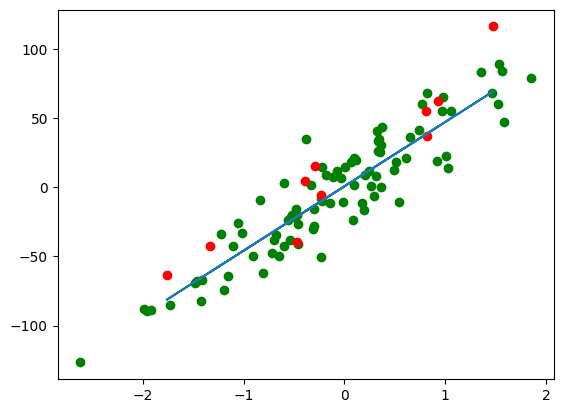

In [5]:
# get data
X, Y = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test regressor
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
loss = np.mean((Y_pred - Y_test)**2)
print(f'loss = {loss}')

# plot
plt.scatter(X_train, Y_train, color='green')
plt.scatter(X_test, Y_test, color='red')
plt.plot(X_test, Y_pred)
plt.show()

#### 3 - Logistic Regression 

In [6]:
class LogisticRegression:

    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        # initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias # get linear value
            Y_pred = self._sigmoid(linear_pred) # apply sigmoid function

            d_weights = (2/n_samples) * np.dot(X.T, (Y_pred - Y)) # weights derivative with respect to loss (cross entropy)
            d_bias = (2/n_samples) * np.sum(Y_pred - Y) # bias derivative with respect to loss (cross entropy)

            # update parameters
            self.weights -= self.lr * d_weights
            self.bias -= self.lr * d_bias

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        Y_pred = self._sigmoid(linear_pred)
        return [1 if y > 0.5 else 0 for y in Y_pred] 
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [ ]:
# get data
bc = datasets.load_breast_cancer()
X, Y = bc.data, bc.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
regressor = LogisticRegression()
regressor.fit(X_train, Y_train)
accuracy = np.sum(regressor.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

There may occur:<br>
RuntimeWarning: overflow encountered in exp<br>
  return 1 / (1 + np.exp(-x))<br>
It means that np.exp(-x) was larger that the largest representable NumPy float. Luckily, we may ignore that particular warning as it doesn't affect our result.

#### 4 - Naive Bayes

In [8]:
class NaiveBayes:

    def fit(self, X, Y):
        # initialize parameters
        n_samples, n_features = X.shape
        self._classes = np.unique(Y)
        self._n_classes = len(self._classes)

        self._mean = np.zeros((self._n_classes, n_features))
        self._var = np.zeros((self._n_classes, n_features))
        self._priors = np.zeros(self._n_classes)

        # calculate mean, variance and frequency
        for i, c in enumerate(self._classes):
            X_c = X[Y == c]
            self._mean[i, :] = X_c.mean(axis=0)
            self._var[i, :] = X_c.var(axis=0)
            self._priors[i] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        Y_pred = [self._predict(x) for x in X]
        return np.array(Y_pred)
    
    def _predict(self, x):
        probs = []
        # calculate probability of every class
        for i in range(self._n_classes):
            prior_prob = np.log(self._priors[i])
            prob = np.sum(np.log(self._prob_dens(i, x))) + prior_prob
            probs.append(prob)

        # get the most probable class
        return self._classes[np.argmax(probs)]

    # get the density
    def _prob_dens(self, class_ix, x):
        mean = self._mean[class_ix]
        var = self._var[class_ix]
        numerator = np.exp(-(x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [9]:
# get data
X, Y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
nb = NaiveBayes()
nb.fit(X_train, Y_train)
accuracy = np.sum(nb.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

accuracy = 0.8


#### 5 - Perceptron

In [10]:
class Perceptron:
    
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.activation_func = self._unit_step

    def fit(self, X, Y):
        # initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # making sure labels are only 1's and 0's 
        y = np.where(Y > 0, 1, 0)

        for _ in range(self.n_iters):
            for i, x_i in enumerate(X):
                # forward pass
                linear = np.dot(x_i, self.weights) + self.bias
                Y_pred = self.activation_func(linear)

                # update parameters
                delta = self.lr * (y[i] - Y_pred)
                self.weights += delta * x_i
                self.bias += delta


    def predict(self, X):
        linear = np.dot(X, self.weights) + self.bias
        Y_pred = self.activation_func(linear)
        return Y_pred

    # activation function
    def _unit_step(self, x):
        return np.where(x >= 0, 1, 0)

accuracy = 1.0


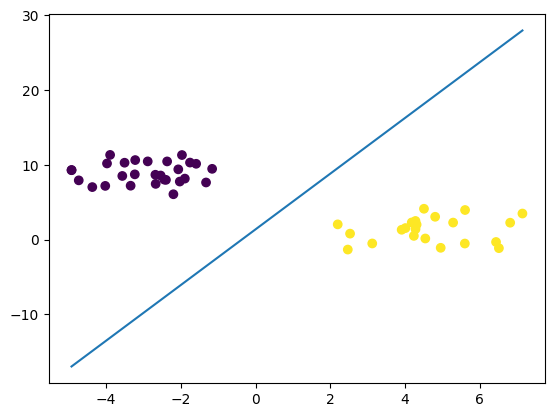

In [11]:
# get data
X, Y = datasets.make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1.5, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
p = Perceptron()
p.fit(X_train, Y_train)
Y_pred = p.predict(X_test)
accuracy = np.sum( Y_pred == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

# plot
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test)

x1_1 = np.amin(X_test[:, 0])
x1_2 = np.amax(X_test[:, 0])
x2_1 = (-p.weights[0] * x1_1 - p.bias) / p.weights[1]
x2_2 = (-p.weights[0] * x1_2 - p.bias) / p.weights[1]

plt.plot([x1_1, x1_2], [x2_1, x2_2])
plt.show()

#### 6 - Support Vector Machine

In [12]:
class SVM:

    def __init__(self, learning_rate = 0.01, lambda_param = 0.01, n_iters = 1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        # initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # making sure labels are only 1's and -1's 
        y = np.where(Y > 0, 1, -1)

        for _ in range(self.n_iters):
            for i, x_i, in enumerate(X):
                # check if classified correctly
                condition = y[i] * (np.dot(x_i, self.weights) - self.bias) >= 1

                # update parameters
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y[i]))
                    self.bias -= self.lr * y[i]

    def predict(self, X):
        linear = np.dot(X, self.weights) - self.bias
        return np.sign(linear)

accuracy = 1.0


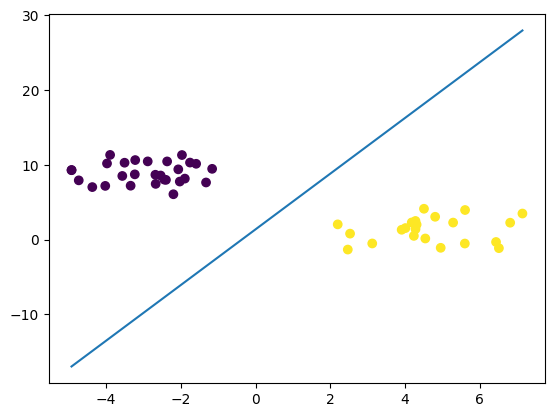

In [13]:
# get data
X, Y = datasets.make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=1.5, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
svm = SVM()
p.fit(X_train, Y_train)
Y_pred = p.predict(X_test)
accuracy = np.sum( Y_pred == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

# plot
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test)

x1_1 = np.amin(X_test[:, 0])
x1_2 = np.amax(X_test[:, 0])
x2_1 = (-p.weights[0] * x1_1 - p.bias) / p.weights[1]
x2_2 = (-p.weights[0] * x1_2 - p.bias) / p.weights[1]

plt.plot([x1_1, x1_2], [x2_1, x2_2])
plt.show()

#### 7 - Decision Tree

In [4]:
# function that calculates entropy in a vector
def entropy(vector):
    histogram = np.bincount(vector)
    freqs = histogram / len(vector)
    return -np.sum([freq * np.log2(freq) for freq in freqs if freq > 0])


class Node:

    def __init__(self, feature = None, threshold = None, left=None, right=None, value=None):
        self.feature = feature # data split criterion
        self.threshold = threshold # data split criterion
        self.left = left #child
        self.right = right #child
        self.value = value

    def is_leaf(self):
        return self.value is not None
    

class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_splt = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, Y):
        # making sure n_features given by user is <= than number of features in the data set
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, Y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, Y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(Y))

        # stopping criteria -> makes leaf node with most popoular value
        if depth >= self.max_depth or n_samples < self.min_samples_splt or n_labels == 1:
            counter = Counter(Y)
            leaf_value = counter.most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # get random features
        feature_idxs = np.random.choice(n_features, self.n_features, replace=False)

        # find which feature+threshold gets best data split
        best_feature, best_threshold = self._best_criteria(X, Y, feature_idxs)

        # split data
        left_idxs = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_idxs = np.argwhere(X[:, best_feature] > best_threshold).flatten()

        # further growing
        left = self._grow_tree(X[left_idxs, :], Y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], Y[right_idxs], depth+1)

        return Node(feature=best_feature, threshold=best_feature, left=left, right=right)

    def _best_criteria(self, X, Y, feature_idxs):
        best_gain = -1
        best_feature_idx, best_threshold = None, None

        # get feature
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            # get threshold
            for threshold in thresholds:
                # caluculate information gain
                gain = self._information_gain(X_column, Y, threshold)
                # find the biggest information gain
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold

    def _information_gain(self, X_coulmn, Y, threshold):
        # calculate parent's entropy
        parent_entropy = entropy(Y)

        # split data
        left_idxs = np.argwhere(X_coulmn <= threshold).flatten()
        right_idxs = np.argwhere(X_coulmn > threshold).flatten()

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # get the number of children
        n = len(Y)
        n_l, n_r =len(left_idxs), len(right_idxs)
        
        # calculate child's entropy
        e_l, e_r = entropy(Y[left_idxs]), entropy(Y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        
        # calulcate information gain
        info_gain = parent_entropy - child_entropy
        return info_gain
    
    def _traverse_tree(self, x, node):
        # if leaf, return value
        if node.is_leaf():
            return node.value
        
        # look for node in correct tree branch
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [45]:
# get data
bc = datasets.load_breast_cancer()
X, Y = bc.data, bc.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
clf = DecisionTree(max_depth=20)
clf.fit(X_train, Y_train)
accuracy = np.sum(clf.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

accuracy = 0.8947368421052632


#### 8 - Random Forest

In [2]:
class RandomForest():

    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_features=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = []

    def fit(self, X, Y):
        self.trees = []

        # make all the trees
        for _ in range(self.n_trees):
            # make a tree
            tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth, n_features=self.n_features)
            # get data sample
            X_sample, Y_sample = self._get_samples(X, Y)
            # optimize the tree
            tree.fit(X_sample, Y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # get all of the predictions
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        # pick the most popular ones
        Y_pred = [self._most_common(tree_pred) for tree_pred in tree_preds]
        return np.array(Y_pred)
        

    def _get_samples(self, X, Y):
        # get random data sample
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], Y[idxs]
    
    def _most_common(self, vec):
        # find most common value in a vector
        counter = Counter(vec)
        return counter.most_common(1)[0][0]

In [7]:
# get data
bc = datasets.load_breast_cancer()
X, Y = bc.data, bc.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)# test the classifier

# test the classifier
clf = RandomForest(n_trees=10, max_depth=10)
clf.fit(X_train, Y_train)
accuracy = np.sum(clf.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

accuracy = 0.8947368421052632


#### 9 - Principal Component Analysis

In [3]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components # wanted dimensionality of the data
        self.components = None
        self.mean = None

    def fit(self, X):
        # calculate the mean
        self.mean = np.mean(X, axis=0)
        # adjust data
        X = X - self.mean
        # get covariance matrix
        cov = np.cov(X, rowvar=False)
        
        # get eigenvalues and eigenvectors of covariance matriv
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        eigenvectors = eigenvectors.T
        
        # sort eigenvalues and eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # get wanted dimensions
        self.components = eigenvectors[0:self.n_components]

    def transform(self, X):
        # adjust data
        X = X - self.mean
        # project data on correct dimensions
        return np.dot(X, self.components.T)


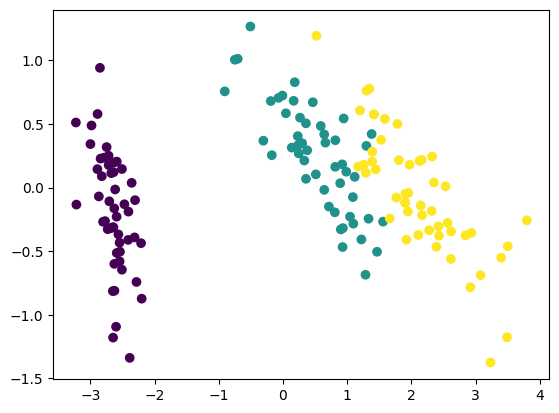

In [5]:
# get data
iris = datasets.load_iris()
X, Y = iris.data, iris.target

# test PCA
pca = PCA(2)
pca.fit(X)
X_projected = pca.transform(X)

# plot
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y)
plt.show()

#### 10 - K-Means Clustering

In [24]:
def euclidean_dist(x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2)) # compute euclidean distance

class KMeans:
        
    def __init__(self, K=5, max_iters=100, plot_steps = False):
        self.K = K # number of wanted clusters
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []

    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # assign random data to centroids
        random_init_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_init_idxs]

        for _ in range(self.max_iters):
            # make clusters with given centroids
            self.clusters = self._create_clusters(self.centroids)
            
            # plotting
            if self.plot_steps:
                self.plot()

            # remember old centroids to check if they converged
            centeroids_old = self.centroids
            # get new centroids from clusters
            self.centroids = self._get_centroids(self.clusters)
            
            # plotting
            if self.plot_steps:
                self.plot()
            
            # check if centroids converged
            if self._is_converged(centeroids_old, self.centroids):
                break

        # label the data accordingly
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(self.clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        
        return labels

    def _create_clusters(self, centeroids):
        clusters = [[] for _ in range(self.K)]
        
        for idx, sample in enumerate(self.X):
            # calculate distances to all centroids
            distances = [euclidean_dist(sample, centroid) for centroid in centeroids]
            
            # assign data to cluster with the nearest centroid
            closest_idx = np.argmin(distances)
            clusters[closest_idx].append(idx)
        
        return clusters
    
    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        
        for cluster_idx, cluster in enumerate(clusters):
            # calculate the centroids for clusters
            centroids[cluster_idx] = np.mean(self.X[cluster], axis=0)
        
        return centroids
    
    def _is_converged(self, old, new):
        distances = [euclidean_dist(old[i], new[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def plot(self):
        # plot data  
        for idx in self.clusters:
            plt.scatter(*self.X[idx].T)
        
        # plot centroids
        for point in self.centroids:
            plt.scatter(*point, marker='x', color='black')

        plt.show()
            

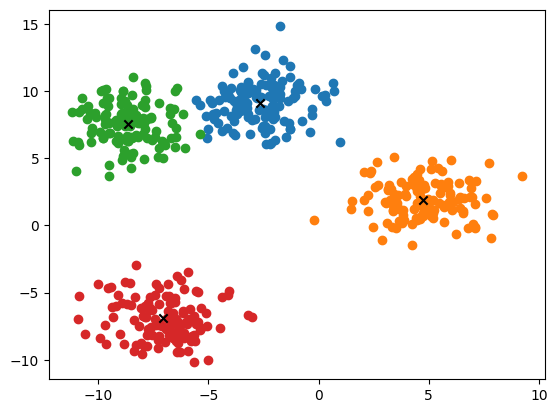

In [34]:
# get data
X, Y = datasets.make_blobs(n_samples=500, n_features=2, centers=4, shuffle=True, cluster_std=1.5, random_state=42)
clusters = len(np.unique(Y))

k = KMeans(K=clusters, max_iters=150, plot_steps=False)
Y_pred = k.predict(X)

# plot
k.plot()

#### 11 - AdaBoost

In [2]:
class DecisionStump:

    def __init__(self):
        self.polarity = 1
        self.feature_idx = None # get wanted features
        self.threshold = None # threshold that is used for classification
        self.alpha = None # accuracy of the classifier

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]

        # assign 1's to all predictions
        predictions = np.ones(n_samples)

        # assign -1's to wrong predictions 
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions


class AdaBoost:

    def __init__(self, n_clf=5):
        self.n_clf = n_clf # number of classifiers

    def fit(self, X, Y):
        n_samples, n_features = X.shape
        self.clfs = []
        
        # initialize weights
        weights = np.full(n_samples, 1/n_samples)
        

        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float('inf')
            
            # for every classifier find the best feature and threshold combination
            for feature_idx in range(n_features):
                X_column = X[:, feature_idx]
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # get predictions with polarity = 1
                    polarity = 1
                    predictions = np.ones(n_samples)
                    predictions[X_column < threshold] = -1
                    
                    # calculate the error
                    missclassified = weights[Y != predictions]
                    error = sum(missclassified)
                    
                    # make sure error is smaller than 0.5 (flip polarity than)
                    if error > 0.5:
                        error = 1 - error
                        polarity = -1

                    # find the smallest error
                    if error < min_error:
                        min_error = error
                        clf.polarity = polarity
                        clf.feature_idx = feature_idx
                        clf.threshold = threshold
            
            EPS = 1e-10 # making sure we don't divide by 0
            # calculate accuracy 
            clf.alpha = 0.5 * np.log((1 - min_error) / (min_error + EPS))

            # update weights
            weights *= np.exp(-clf.alpha * Y * clf.predict(X))
            weights /= np.sum(weights)

            self.clfs.append(clf)

    def predict(self, X):
        # calulate predictions for every classifier
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        # sum predictions
        Y_pred = np.sum(clf_preds, axis=0)
        return np.sign(Y_pred)

In [4]:
# get data
bc = datasets.load_breast_cancer()
X, Y = bc.data, bc.target
Y[Y == 0] = -1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# test the classifier
clf = AdaBoost()
clf.fit(X_train, Y_train)
accuracy = np.sum(clf.predict(X_test) == Y_test) / len(Y_test)
print(f'accuracy = {accuracy}')

accuracy = 0.9824561403508771


#### Linear Discriminant Analysis

In [65]:
class LDA:

    def __init__(self, n_components):
        self.n_components = n_components # wanted dimensionality of the data
        self.linear_discriminants = None

    def fit(self, X, Y):
        n_features = X.shape[1]
        
        # get the number of unique classes
        class_labels = np.unique(Y)
        # calculate the mean of all data
        mean_overall = np.mean(X, axis=0)
        
        # initialize ...
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        
        for class_label in class_labels:
            # get specific class
            X_class = X[Y == class_label]

            # calulcate hte mean within that class
            mean_class = np.mean(X_class, axis=0)

            S_W += (X_class - mean_class).T.dot(X_class - mean_class)
            
            # get the number of data point within that class
            n_class = X_class.shape[0]

            # calulate mean difference
            mean_diff = (mean_class - mean_overall).reshape(n_features, 1)
            
            S_B += n_class * (mean_diff).dot(mean_diff.T)

        A = np.linalg.inv(S_W).dot(S_B)
        

        # get eigenvalues and eigenvectors of A matrix        
        eigenvalues, eigenvectors = np.linalg.eig(A)
        eigenvectors = eigenvectors.T
        
        # sort eigenvalues and eigenvectors
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # get wanted dimensions
        self.linear_discriminants = eigenvectors[0:self.n_components]
    
    
    def transform(self, X):
        # project data on correct dimensions
        return np.dot(X, self.linear_discriminants.T)

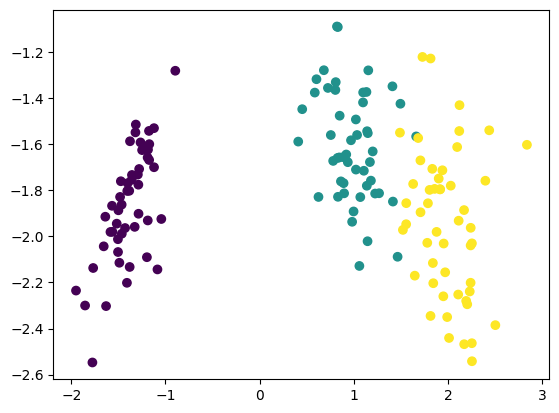

In [66]:
iris = datasets.load_iris()
X, Y = iris.data, iris.target

lda = LDA(2)
lda.fit(X, Y)
X_projected = lda.transform(X)

# plot
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y)
plt.show()